In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm

In [2]:
from sklearn_extra.cluster import KMedoids
from scipy.stats import wasserstein_distance

# Import and Cleaning

In [3]:
df = pd.read_csv('E:\Documents\Google Drive\Eskwelabs\Sprint 5 - Capstone\data\consolidated_csv_01SUAL_G01.csv')
df.head()

,RUN_TIME,MKT_TYPE,REGION_NAME,ZONE_NAME,RESOURCE_NAME,TIME_INTERVAL,START_TIME,END_TIME,MP_NAME,PRICE1,...,RR_BREAK_QUANTITY3,RR_UP3,RR_DOWN3,RR_BREAK_QUANTITY4,RR_UP4,RR_DOWN4,RR_BREAK_QUANTITY5,RR_UP5,RR_DOWN5,Unnamed: 46
0,06/26/2021,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:05:00 AM,06/26/2021,06/26/2021 12:05:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06/26/2021 12:05:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:10:00 AM,06/26/2021 12:05:00 AM,06/26/2021 12:10:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06/26/2021 12:10:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:15:00 AM,06/26/2021 12:10:00 AM,06/26/2021 12:15:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06/26/2021 12:15:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:20:00 AM,06/26/2021 12:15:00 AM,06/26/2021 12:20:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06/26/2021 12:20:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:25:00 AM,06/26/2021 12:20:00 AM,06/26/2021 12:25:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Define the columns containing price-quantity pairs and timestamps
price_columns = [f'PRICE{i}' for i in range(1, 12)]
quantity_columns = [f'QUANTITY{i}' for i in range(1, 12)]

# specify selected price-quantity columns
selected_columns = ['RUN_TIME'] + [price for price in price_columns] + [quantity for quantity in quantity_columns]

In [5]:
pd.set_option('display.max_columns', None)

# Apply the selection to the filtered DataFrame
result_df = df[selected_columns]

#change Uppercase to lowercase
result_df.columns = result_df.columns.str.lower()

In [6]:
# Convert 'run_time' to datetime with multiple formats
result_df['temp_run_time'] = pd.to_datetime(result_df['run_time'], errors='coerce', format='%m/%d/%Y %I:%M:%S %p').copy()

# Handle military-time entries separately
mask_date_only = result_df['temp_run_time'].dt.time == pd.Timestamp('00:00:00').time()
result_df['run_time'] = result_df['temp_run_time'].where(mask_date_only, result_df['temp_run_time'].combine_first(pd.to_datetime(result_df['temp_run_time'], errors='coerce', format='%m/%d/%Y')))

# Drop the temporary column
result_df.drop(columns=['temp_run_time'], inplace=True)

# Print the result
result_df.head()

C:\Users\Gaea\AppData\Local\Temp\ipykernel_38476\2423218759.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['temp_run_time'] = pd.to_datetime(result_df['run_time'], errors='coerce', format='%m/%d/%Y %I:%M:%S %p').copy()
C:\Users\Gaea\AppData\Local\Temp\ipykernel_38476\2423218759.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['run_time'] = result_df['temp_run_time'].where(mask_date_only, result_df['temp_run_time'].combine_first(pd.to_datetime(result_df['temp_run_time'], errors='c

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,quantity1,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,NaT,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-26 00:05:00,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-06-26 00:10:00,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-06-26 00:15:00,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-06-26 00:20:00,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Downsample to only every hour

In [7]:
starting_index = 6 #start sampling at 6th index to get all 0030hr entries
downsampled_df = result_df.iloc[starting_index::12, :].copy()
downsampled_df.reset_index(drop=True, inplace=True)
downsampled_df

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,quantity1,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,2021-06-26 00:30:00,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-26 01:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,NaN,NaN,NaN,NaN,0.0,450.0,538.2,556.0,560.0,600.0,647.0,NaN,NaN,NaN,NaN
2,2021-06-26 02:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,NaN,NaN,NaN,NaN,0.0,350.0,436.2,456.0,560.0,600.0,647.0,NaN,NaN,NaN,NaN
3,2021-06-26 03:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,NaN,NaN,NaN,NaN,0.0,350.0,435.0,456.0,560.0,600.0,647.0,NaN,NaN,NaN,NaN
4,2021-06-26 04:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,NaN,NaN,NaN,NaN,0.0,350.0,436.9,456.0,560.0,600.0,647.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17309,2023-09-25 19:20:00,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,8000.08,NaN,0.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN
17310,2023-09-25 20:20:00,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,8000.08,NaN,0.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN
17311,2023-09-25 21:20:00,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,8000.08,NaN,0.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN
17312,2023-09-25 22:20:00,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,8000.08,NaN,0.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN


## FFill NaNs with last Price-Quantity bid

In [8]:
# Forward fill from the first non-null value in each row for the price columns
downsampled_df.loc[:, 'price1':'price11'] = downsampled_df.loc[:, 'price1':'price11'].apply(lambda row: row.ffill(), axis=1)

# Forward fill from the first non-null value in each row for the quantity columns
downsampled_df.loc[:, 'quantity1':'quantity11'] = downsampled_df.loc[:, 'quantity1':'quantity11'].apply(lambda row: row.ffill(), axis=1)

downsampled_df.head()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,quantity1,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,2021-06-26 00:30:00,-10000.0,-10000.0,2214.38,2465.69,2465.69,2465.69,2465.69,2465.69,2465.69,2465.69,2465.69,0.0,541.0,632.7,647.0,647.0,647.0,647.0,647.0,647.0,647.0,647.0
1,2021-06-26 01:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,2490.08,2490.08,2490.08,2490.08,0.0,450.0,538.2,556.0,560.0,600.0,647.0,647.0,647.0,647.0,647.0
2,2021-06-26 02:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,2490.08,2490.08,2490.08,2490.08,0.0,350.0,436.2,456.0,560.0,600.0,647.0,647.0,647.0,647.0,647.0
3,2021-06-26 03:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,2490.08,2490.08,2490.08,2490.08,0.0,350.0,435.0,456.0,560.0,600.0,647.0,647.0,647.0,647.0,647.0
4,2021-06-26 04:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,2490.08,2490.08,2490.08,2490.08,0.0,350.0,436.9,456.0,560.0,600.0,647.0,647.0,647.0,647.0,647.0


## MinMaxScaler on Quantity values

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Extract only the quantity columns for normalization
quantity_columns = [f'quantity{i}' for i in range(1, 12)]

# Flatten the DataFrame and extract only quantity columns
flattened_quantities = downsampled_df[quantity_columns].values.flatten()

# Reshape the flattened quantities to a column vector
flattened_quantities = flattened_quantities.reshape(-1, 1)

# Use MinMaxScaler on the flattened quantities
scaler = MinMaxScaler()
scaled_quantities = scaler.fit_transform(flattened_quantities)

# Reshape the scaled quantities to match the original DataFrame shape
scaled_quantities = scaled_quantities.reshape(downsampled_df[quantity_columns].shape)

# Update the DataFrame with the scaled values
downsampled_df.loc[:, quantity_columns] = scaled_quantities

## Filter to only 2022

In [10]:
# Filter rows within the year 2022
df_2022 = downsampled_df[(downsampled_df['run_time'] >= '2022-01-01') & (downsampled_df['run_time'] < '2023-01-01')]

# Reset index
df_2022 = df_2022.reset_index(drop=True)
df_2022

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,quantity1,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,2022-01-01 00:15:00,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.426893,0.550232,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
1,2022-01-01 01:15:00,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.412056,0.550232,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
2,2022-01-01 02:15:00,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.411747,0.550232,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
3,2022-01-01 03:15:00,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.411283,0.550232,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
4,2022-01-01 04:15:00,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.411128,0.550232,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7943,2022-12-31 19:30:00,-10000.0,-10000.0,9200.08,9260.08,9280.08,9300.08,9300.08,9300.08,9300.08,9300.08,9300.08,0.0,0.370943,0.540958,0.695518,0.836167,1.0,1.0,1.0,1.0,1.0,1.0
7944,2022-12-31 20:30:00,-10000.0,-10000.0,9200.08,9260.08,9280.08,9300.08,9300.08,9300.08,9300.08,9300.08,9300.08,0.0,0.370943,0.540958,0.695518,0.836167,1.0,1.0,1.0,1.0,1.0,1.0
7945,2022-12-31 21:30:00,-10000.0,-10000.0,9200.08,9260.08,9280.08,9300.08,9300.08,9300.08,9300.08,9300.08,9300.08,0.0,0.370943,0.540958,0.695518,0.836167,1.0,1.0,1.0,1.0,1.0,1.0
7946,2022-12-31 22:30:00,-10000.0,-10000.0,9200.08,9260.08,9280.08,9300.08,9300.08,9300.08,9300.08,9300.08,9300.08,0.0,0.370943,0.540958,0.695518,0.836167,1.0,1.0,1.0,1.0,1.0,1.0


## EDA

In [11]:
df_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7948 entries, 0 to 7947
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   run_time    7948 non-null   datetime64[ns]
 1   price1      7948 non-null   float64       
 2   price2      7948 non-null   float64       
 3   price3      7948 non-null   float64       
 4   price4      7948 non-null   float64       
 5   price5      7948 non-null   float64       
 6   price6      7948 non-null   float64       
 7   price7      7948 non-null   float64       
 8   price8      7948 non-null   float64       
 9   price9      7948 non-null   float64       
 10  price10     7948 non-null   float64       
 11  price11     7948 non-null   float64       
 12  quantity1   7948 non-null   float64       
 13  quantity2   7948 non-null   float64       
 14  quantity3   7948 non-null   float64       
 15  quantity4   7948 non-null   float64       
 16  quantity5   7948 non-nul

In [12]:
df_2022.describe()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,quantity1,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
count,7948,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.0,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000
mean,2022-06-23 14:35:08.303975680,-9989.431303,-9989.431303,1682.185664,2044.415052,2467.659250,2498.616135,2508.004112,2511.351163,2512.436970,2512.820715,2512.820715,0.0,0.733029,0.803984,0.867660,0.914869,0.938145,0.950101,0.955763,0.957945,0.958702,0.958702
min,2022-01-01 00:15:00,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,0.0,0.347759,0.347759,0.347759,0.347759,0.347759,0.347759,0.347759,0.347759,0.347759,0.347759
25%,2022-03-28 08:50:00,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,0.0,0.540958,0.695518,0.772798,0.850077,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2022-06-19 14:35:00,-10000.000000,-10000.000000,4593.980000,5005.080000,6300.080000,6500.080000,6500.080000,6500.080000,6500.080000,6500.080000,6500.080000,0.0,0.772798,0.850077,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,2022-09-10 11:45:00,-10000.000000,-10000.000000,9000.080000,9200.080000,9500.080000,9550.080000,9550.080000,9600.080000,9600.080000,9600.080000,9600.080000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2022-12-31 23:30:00,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,666.205222,666.205222,9236.068301,9404.612582,9777.426018,9810.684145,9816.987246,9819.435874,9820.254689,9820.540567,9820.540567,0.0,0.220121,0.190100,0.171005,0.152746,0.145265,0.141387,0.140044,0.139647,0.139679,0.139679


## Check for NaNs

In [13]:
missing_values = df_2022.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
run_time      0
price1        0
price2        0
price3        0
price4        0
price5        0
price6        0
price7        0
price8        0
price9        0
price10       0
price11       0
quantity1     0
quantity2     0
quantity3     0
quantity4     0
quantity5     0
quantity6     0
quantity7     0
quantity8     0
quantity9     0
quantity10    0
quantity11    0
dtype: int64


## Visualize with Histograms

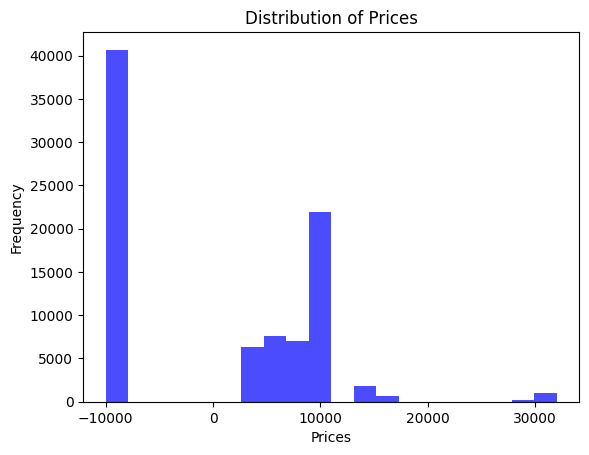

In [14]:
# Extract prices from df_2022
prices_columns = [f'price{i}' for i in range(1, 12)]
prices = df_2022[prices_columns].values.flatten()

# Plot histogram
plt.hist(prices, bins=20, color='blue', alpha=0.7)
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.title('Distribution of Prices')
plt.show()

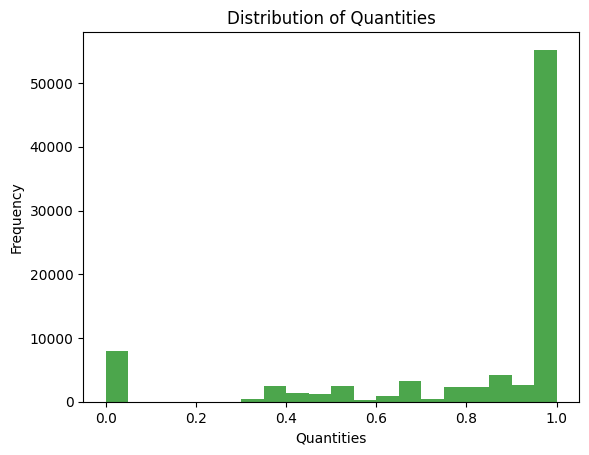

In [15]:
# Extract quantities from df_2022
quantities_columns = [f'quantity{i}' for i in range(1, 12)]
quantities = df_2022[quantities_columns].values.flatten()

# Plot histogram
plt.hist(quantities, bins=20, color='green', alpha=0.7)
plt.xlabel('Quantities')
plt.ylabel('Frequency')
plt.title('Distribution of Quantities')
plt.show()

# K-medoids on subset of 2022 data

## Re-shape df into array

#### Select subset of df

In [16]:
# Select only the first 100 entries from df_2022
df_subset = df_2022.head(100)

#### Test plot random bid curves from df_subset

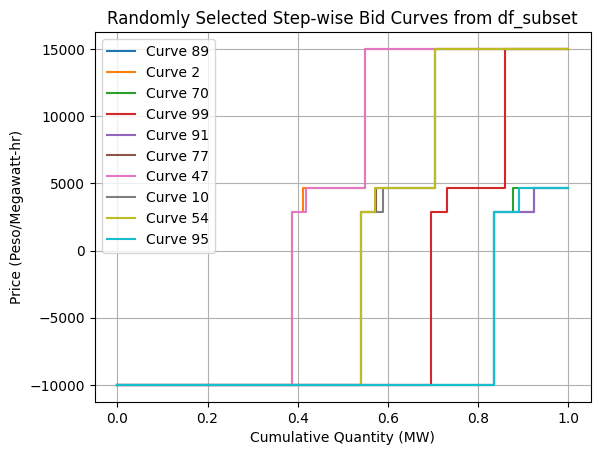

In [17]:
# Test Plot random indices from subset df
# Randomly select 10 indices
random_indices = df_subset.sample(n=10).index

# Extract prices and cumulative quantities for the randomly selected indices
selected_prices = df_subset.loc[random_indices, 'price1':'price11'].values
selected_cumulative_quantities = df_subset.loc[random_indices, 'quantity1':'quantity11'].values

# Plotting the selected step-wise bid curves
for i, idx in enumerate(random_indices):
    cumulative_quantity = selected_cumulative_quantities[i]
    price = selected_prices[i]
    plt.step(cumulative_quantity, price, where='pre', label=f'Curve {idx}')

plt.xlabel('Cumulative Quantity (MW)')
plt.ylabel('Price (Peso/Megawatt-hr)')
plt.title('Randomly Selected Step-wise Bid Curves from df_subset')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Display the subset of df_subset for the randomly selected indices
df_subset_random = df_subset.loc[random_indices]
df_subset_random.head()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,quantity1,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
89,2022-01-04 17:15:00,-10000.0,-10000.0,2862.2,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,0.0,0.836167,0.924266,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2022-01-01 02:15:00,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.411747,0.550232,1.0,1.0,1.0,1.0,1.0,1.0,1.0
70,2022-01-03 22:15:00,-10000.0,-10000.0,2862.2,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,0.0,0.836167,0.876816,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
99,2022-01-05 03:15:00,-10000.0,-10000.0,2862.2,4646.81,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.695518,0.730603,0.859351,1.0,1.0,1.0,1.0,1.0,1.0,1.0
91,2022-01-04 19:15:00,-10000.0,-10000.0,2862.2,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,0.0,0.836167,0.923338,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#### Make (quantity,price) tuples

In [19]:
# Get values from columns
prices = df_subset[['price1', 'price2', 'price3', 'price4', 'price5', 'price6', 'price7', 'price8', 'price9', 'price10', 'price11']].values
quantities = df_subset[['quantity1', 'quantity2', 'quantity3', 'quantity4', 'quantity5', 'quantity6', 'quantity7', 'quantity8', 'quantity9', 'quantity10', 'quantity11']].values

# Create list of lists containting (quantity,prices) tuples
def create_stepwise_curves(quantities, prices):
    step_curves = []
    for i in range(len(prices)):
        step_curves.append(list(zip(quantities[i], prices[i])))
    return step_curves

step_curves = create_stepwise_curves(quantities, prices)

In [20]:
# Check length of step_curves
num_curves = len(step_curves)
length_of_first_curve = len(step_curves[0]) if num_curves > 0 else 0

print(f"Number of curves: {num_curves}")
print(f"Length of the first curve: {length_of_first_curve}")

Number of curves: 100
Length of the first curve: 11


#### Change step_curves into array

In [21]:
# Change step_curves into 2D numpy array
step_curves_array = np.array(step_curves).reshape(len(step_curves), -1)

In [22]:
print("Shape of step_curves_array:", step_curves_array.shape)

Shape of step_curves_array: (100, 22)


## Initialize functions

In [23]:
from sklearn_extra.cluster import KMedoids
from scipy.stats import wasserstein_distance
from joblib import Parallel, delayed
import numpy as np

# Function to calculate Wasserstein distance
def wasserstein_dist(p1, p2):
    return wasserstein_distance(p1, p2)

# Function to perform K-medoids clustering
def kmedoids_clustering(data, k):
    kmedoids = KMedoids(n_clusters=k, metric=wasserstein_dist, random_state=42)
    kmedoids.fit(data)
    return kmedoids.labels_, kmedoids.cluster_centers_

# Function to calculate Separation Threshold
def calculate_separation_threshold(labels, centers, separation_threshold, p_ref):
    k = len(centers)
    s_ref = wasserstein_dist(centers[0], p_ref)  # Assuming P_ref is the first center
    s_th = separation_threshold * s_ref
    
    for i in range(k):
        distances_within_cluster = [
            wasserstein_dist(step_curves_array[j], centers[i]) 
            for j in range(len(labels)) if labels[j] == i
        ]
        rho_i = sum(1 for dist in distances_within_cluster if dist > s_th) / len(distances_within_cluster)

        if rho_i > tolerance_rate:
            return True

    return False

# Modify process_chunk to return labels along with result
def process_chunk(K, step_curves_array, separation_threshold, tolerance_rate):
    labels, centers = kmedoids_clustering(step_curves_array, K)
    print(f"Processed chunk for K={K}: Labels: {labels}, Centers Shape: {np.shape(centers)}")

    # Check for empty clusters
    empty_clusters = [i for i, cluster_size in enumerate(np.bincount(labels)) if cluster_size == 0]
    if empty_clusters:
        print(f"Warning: Empty clusters found for K={K}, Cluster indices: {empty_clusters}")

    # Print debugging information
    print("Cluster Centers:")
    print(centers)

    result = calculate_separation_threshold(labels, centers, separation_threshold, step_curves_array[0])

    return result, labels, centers


# Function to find optimal number of clusters
def find_optimal_clusters(step_curves_array, K_0, K_max, initial_chunk_size, iterations_within_chunk, separation_threshold, tolerance_rate):
    step_curves_array = step_curves_array.astype(np.float32)
    
    # Initialization
    K = K_0
    P_ref = step_curves_array[0]  # Using the first curve as a reference

    # Initialize the variable to track the optimal number of clusters
    optimal_K = K_0  

    # Store cluster centers and labels here
    centers_list = []  
    labels_list = []

    while K <= K_max:  
        print(f"Processing chunk for K={K}")

        result_found = False  # Flag to track whether a result was found in the inner loop
        # Inside your loop in find_optimal_clusters function
        for _ in range(iterations_within_chunk):
            chunk_size = min(initial_chunk_size, K_max - K)
            chunk_results = list(Parallel(n_jobs=-1)(delayed(process_chunk)(K + i, step_curves_array, separation_threshold, tolerance_rate) for i in range(chunk_size)))

            for result, labels, centers in chunk_results:
                if result:
                    optimal_K = K  # Update the optimal_K variable
                    centers_list.append(centers)
                    labels_list.append(labels)
                    result_found = True
                    break

            if result_found:
                break  # Break out of the inner loop if a result is found
                
        if result_found:
            break  # Break out of the outer loop if a result is found

        # Increment K after the chunk is processed
        K += chunk_size

    # Now optimal_K contains the optimal number of clusters, up to K_max
    print(f"Optimal number of clusters (K): {optimal_K}")
    
    # Return the labels_list
    return labels_list, centers_list

## Specify parameters

In [24]:
# Parameters
K_0 = 2
K_max = 4  # Choose a smaller value for testing
separation_threshold = 0.01  # 1% as separation_threshold_ratio, increase if you think clusters should have larger dissimilarity
tolerance_rate = 0.05  # original was 0.1, increase if you want to be more strict about considering a cluster as separate

# Initial chunk size
initial_chunk_size = 5000
# Number of iterations within each chunk
iterations_within_chunk = 100

## Run

In [25]:
%%time
# Find optimal clusters
found_labels_list, found_centers_list = find_optimal_clusters(step_curves_array, K_0, K_max, initial_chunk_size, iterations_within_chunk, separation_threshold, tolerance_rate)

Processing chunk for K=2
Optimal number of clusters (K): 2
CPU times: total: 62.5 ms
Wall time: 1.16 s


## Results

### Apply cluster label to df

In [26]:
# Assuming 'found_labels_list' is your list of labels after clustering
cluster_labels = found_labels_list[0]

# Create a copy of the subset to avoid SettingWithCopyWarning
df_subset_copy = df_subset.copy()

# Add 'cluster_no' column to df_subset_copy using .loc
df_subset_copy.loc[:, 'cluster_no'] = cluster_labels.copy()

# Now df_subset_copy has the 'cluster_no' column added without warnings
df_subset_copy


,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,quantity1,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11,cluster_no
0,2022-01-01 00:15:00,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.426893,0.550232,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
1,2022-01-01 01:15:00,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.412056,0.550232,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
2,2022-01-01 02:15:00,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.411747,0.550232,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
3,2022-01-01 03:15:00,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.411283,0.550232,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
4,2022-01-01 04:15:00,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.411128,0.550232,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2022-01-04 23:15:00,-10000.0,-10000.0,2862.2,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,0.0,0.836167,0.891808,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
96,2022-01-05 00:15:00,-10000.0,-10000.0,2862.2,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,0.0,0.836167,0.879134,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
97,2022-01-05 01:15:00,-10000.0,-10000.0,2862.2,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,0.0,0.836167,0.879134,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
98,2022-01-05 02:15:00,-10000.0,-10000.0,2862.2,4646.81,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.803709,0.851159,0.967543,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0


### Display cluster medoids

In [27]:
# Assuming 'centers_list' is your list of cluster centers
final_centers = found_centers_list[-1]

# Assuming 'final_centers' is your cluster centers
num_features = final_centers.shape[1]
feature_columns = [f'quantity{i//2 + 1}' if i % 2 == 0 else f'price{i//2 + 1}' for i in range(num_features)]
centers_df = pd.DataFrame(final_centers, columns=feature_columns)
centers_df


,quantity1,price1,quantity2,price2,quantity3,price3,quantity4,price4,quantity5,price5,quantity6,price6,quantity7,price7,quantity8,price8,quantity9,price9,quantity10,price10,quantity11,price11
0,0.0,-10000.0,0.540958,-10000.0,0.574034,2862.199951,0.704791,4646.810059,1.0,15000.080078,1.0,15000.080078,1.0,15000.080078,1.0,15000.080078,1.0,15000.080078,1.0,15000.080078,1.0,15000.080078
1,0.0,-10000.0,0.836167,-10000.0,0.893354,2862.199951,1.000000,4646.810059,1.0,4646.810059,1.0,4646.810059,1.0,4646.810059,1.0,4646.810059,1.0,4646.810059,1.0,4646.810059,1.0,4646.810059


### Visualize curves

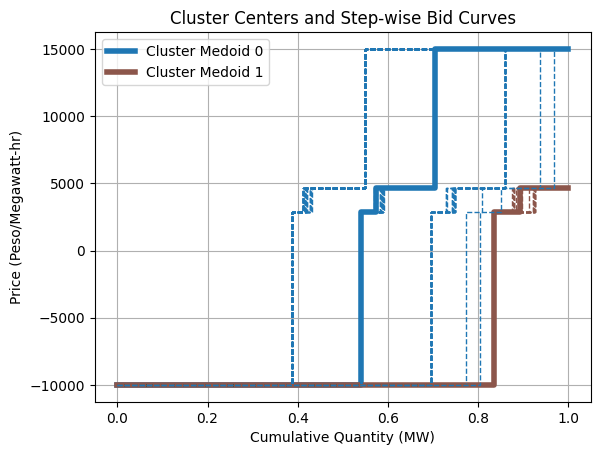

CPU times: total: 219 ms
Wall time: 222 ms


In [28]:
%%time
# Plotting parameters
thick_line_width = 4
thin_line_width = 1.0

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Get a color map
color_map = plt.get_cmap('tab10')

# Plotting cluster centers from 'centers_df' as thick lines
for index, center_row in centers_df.iterrows():
    cumulative_quantity, price = center_row.values.reshape(-1, 2).T
    plt.step(cumulative_quantity, price, where='pre', linewidth=thick_line_width, label=f'Cluster Medoid {index}', color=color_map(index / len(centers_df)))

# Plotting step-wise bid curves from 'df_subset_copy' as thinner lines
for index, row in df_subset_copy.iterrows():
    cluster_no = row['cluster_no']
    cumulative_quantity, price = row[['quantity1', 'price1', 'quantity2', 'price2', 'quantity3', 'price3', 'quantity4', 'price4', 'quantity5', 'price5', 'quantity6', 'price6', 'quantity7', 'price7', 'quantity8', 'price8', 'quantity9', 'price9', 'quantity10', 'price10', 'quantity11', 'price11']].values.reshape(-1, 2).T
    plt.step(cumulative_quantity, price, where='pre', linewidth=thin_line_width, linestyle='--', color=color_map(cluster_no / len(centers_df)))

# Plotting settings
plt.xlabel('Cumulative Quantity (MW)')
plt.ylabel('Price (Peso/Megawatt-hr)')
plt.title('Cluster Centers and Step-wise Bid Curves')
plt.legend()
plt.grid(True)
plt.show()

# K-medoids on entire 2022 df

In [32]:
# Select only the first 100 entries from df_2022
df_subset = df_2022.head(7948)

# Get values from columns
prices = df_subset[['price1', 'price2', 'price3', 'price4', 'price5', 'price6', 'price7', 'price8', 'price9', 'price10', 'price11']].values
quantities = df_subset[['quantity1', 'quantity2', 'quantity3', 'quantity4', 'quantity5', 'quantity6', 'quantity7', 'quantity8', 'quantity9', 'quantity10', 'quantity11']].values

# Function to create step-wise bid curves
def create_stepwise_curves(prices, quantities):
    step_curves = []
    for i in range(len(prices)):
        step_curves.append(list(zip(quantities[i], prices[i])))
    return step_curves

step_curves = create_stepwise_curves(prices, quantities)


In [33]:
num_curves = len(step_curves)
length_of_first_curve = len(step_curves[0]) if num_curves > 0 else 0

print(f"Number of curves: {num_curves}")
print(f"Length of the first curve: {length_of_first_curve}")

Number of curves: 7948
Length of the first curve: 11


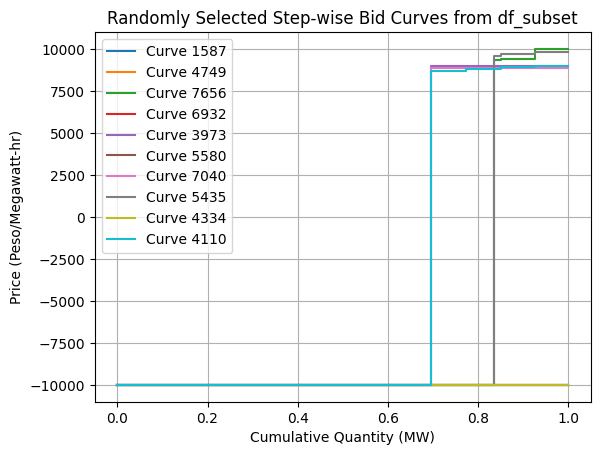

In [34]:
# Test Plot random indices
# Randomly select 10 indices
random_indices = df_subset.sample(n=10).index

# Extract prices and cumulative quantities for the randomly selected indices
selected_prices = df_subset.loc[random_indices, 'price1':'price11'].values
selected_cumulative_quantities = df_subset.loc[random_indices, 'quantity1':'quantity11'].values

# Plotting the selected step-wise bid curves
for i, idx in enumerate(random_indices):
    cumulative_quantity = selected_cumulative_quantities[i]
    price = selected_prices[i]
    plt.step(cumulative_quantity, price, where='pre', label=f'Curve {idx}')

plt.xlabel('Cumulative Quantity (MW)')
plt.ylabel('Price (Peso/Megawatt-hr)')
plt.title('Randomly Selected Step-wise Bid Curves from df_subset')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Display the subset of df_subset for the randomly selected indices
df_subset_random = df_subset.loc[random_indices]
df_subset_random.head()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,quantity1,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
1587,2022-03-11 14:35:00,-10000.0,-10000.0,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,0.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4749,2022-07-21 22:25:00,-10000.0,-10000.0,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,0.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7656,2022-12-17 07:20:00,-10000.0,-10000.0,9370.08,9400.08,10000.08,10000.08,10000.08,10000.08,10000.08,10000.08,10000.08,0.0,0.836167,0.850077,0.927357,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6932,2022-11-15 14:00:00,-10000.0,-10000.0,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,0.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3973,2022-06-19 14:05:00,-10000.0,-10000.0,9000.08,9000.08,9000.08,9000.08,9000.08,9000.08,9000.08,9000.08,9000.08,0.0,0.695518,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [36]:
# Change step_curves into numpy array
step_curves_array = np.array(step_curves).reshape(len(step_curves), -1)

In [37]:
print("Shape of step_curves_array:", step_curves_array.shape)

Shape of step_curves_array: (7948, 22)


## Run

In [38]:
%%time
from sklearn_extra.cluster import KMedoids
from scipy.stats import wasserstein_distance
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

# Function to calculate Wasserstein distance
def wasserstein_dist(p1, p2):
    return wasserstein_distance(p1, p2)

# Function to perform K-medoids clustering
def kmedoids_clustering(data, k):
    kmedoids = KMedoids(n_clusters=k, metric=wasserstein_dist, random_state=42)
    kmedoids.fit(data)
    return kmedoids.labels_, kmedoids.cluster_centers_

# Function to calculate Separation Threshold
def separation_threshold_ratio(labels, centers, theta_0, p_ref):
    k = len(centers)
    s_ref = wasserstein_dist(centers[0], p_ref)  # Assuming P_ref is the first center
    s_th = theta_0 * s_ref
    
    for i in range(k):
        distances_within_cluster = [
            wasserstein_dist(step_curves_array[j], centers[i]) 
            for j in range(len(labels)) if labels[j] == i
        ]
        rho_i = sum(1 for dist in distances_within_cluster if dist > s_th) / len(distances_within_cluster)

        if rho_i > RHO_0:
            return True

    return False

# Function to process a chunk
def process_chunk(K):
    labels, centers = kmedoids_clustering(step_curves_array, K)
    print(f"Processed chunk for K={K}: Labels: {labels}, Centers Shape: {np.shape(centers)}")

    # Check for empty clusters
    empty_clusters = [i for i, cluster_size in enumerate(np.bincount(labels)) if cluster_size == 0]
    if empty_clusters:
        print(f"Warning: Empty clusters found for K={K}, Cluster indices: {empty_clusters}")

    # Add more debugging information or checks as needed

    return separation_threshold_ratio(labels, centers, THETA_0, P_ref), centers

CPU times: total: 62.5 ms
Wall time: 59.1 ms


In [39]:
# Parameters
K_0 = 2
K_max = 7  # Choose a smaller value for testing
THETA_0 = 0.01  # 1% as THETA_0
RHO_0 = 0.075 #original was 0.1

# Initial chunk size
initial_chunk_size = 5000
# Number of iterations within each chunk
iterations_within_chunk = 500

# Reduce memory usage
step_curves_array = step_curves_array.astype(np.float32)

# Initialization
K = K_0
P_ref = step_curves_array[0]  # Using the first curve as a reference

# Initialize the variable to track the optimal number of clusters
optimal_K = K_0  

# Store cluster centers and labels here
centers_list = []  
labels_list = []

In [40]:
%%time
with tqdm(total=K_max - K_0 + 1, desc="Iterating through K clusters") as pbar:
    while K <= K_max:  
        pbar.set_postfix({"Current K": K})

        # Dynamic chunk size based on remaining clusters
        remaining_clusters = K_max - K
        chunk_size = min(initial_chunk_size, remaining_clusters)

        print(f"Processing chunk for K={K}")

        result_found = False  # Flag to track whether a result was found in the inner loop

        for _ in range(iterations_within_chunk):
            # Use `list()` to force the progress bar to update in a Jupyter Notebook
            chunk_results = list(Parallel(n_jobs=-1)(delayed(process_chunk)(K + i) for i in range(chunk_size)))

            for result, centers in chunk_results:
                if result:
                    optimal_K = K  # Update the optimal_K variable
                    centers_list.append(centers)
                    labels_list.append(kmedoids_clustering(step_curves_array, K)[0])
                    result_found = True
                    break

            if result_found:
                break  # Break out of the inner loop if a result is found

            pbar.update(1)  

            # Print additional information every 100 iterations
            if K % 100 == 0:
                print(f"Current iteration: {K}, Result: {result}")

        if result_found:
            break  # Break out of the outer loop if a result is found

        # Increment K after the chunk is processed
        K += chunk_size

# Now optimal_K contains the optimal number of clusters, up to K_max
print(f"Optimal number of clusters (K): {optimal_K}")

Iterating through K clusters:   0%|          | 0/6 [00:00<?, ?it/s]

Processing chunk for K=2


C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Optimal number of clusters (K): 2
CPU times: total: 10min 39s
Wall time: 23min


In [41]:
labels_list

[array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]

In [42]:
# Assuming 'labels_list' is your list of labels after K-means clustering
cluster_labels = labels_list[0]

# Add 'cluster_no' column to df_subset using .loc
df_subset.loc[:, 'cluster_no'] = cluster_labels
df_subset

C:\Users\Gaea\AppData\Local\Temp\ipykernel_38476\3693949184.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'cluster_no'] = cluster_labels


,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,quantity1,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11,cluster_no
0,2022-01-01 00:15:00,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.426893,0.550232,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0
1,2022-01-01 01:15:00,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.412056,0.550232,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0
2,2022-01-01 02:15:00,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.411747,0.550232,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0
3,2022-01-01 03:15:00,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.411283,0.550232,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0
4,2022-01-01 04:15:00,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.411128,0.550232,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7943,2022-12-31 19:30:00,-10000.0,-10000.0,9200.08,9260.08,9280.08,9300.08,9300.08,9300.08,9300.08,9300.08,9300.08,0.0,0.370943,0.540958,0.695518,0.836167,1.0,1.0,1.0,1.0,1.0,1.0,0
7944,2022-12-31 20:30:00,-10000.0,-10000.0,9200.08,9260.08,9280.08,9300.08,9300.08,9300.08,9300.08,9300.08,9300.08,0.0,0.370943,0.540958,0.695518,0.836167,1.0,1.0,1.0,1.0,1.0,1.0,0
7945,2022-12-31 21:30:00,-10000.0,-10000.0,9200.08,9260.08,9280.08,9300.08,9300.08,9300.08,9300.08,9300.08,9300.08,0.0,0.370943,0.540958,0.695518,0.836167,1.0,1.0,1.0,1.0,1.0,1.0,0
7946,2022-12-31 22:30:00,-10000.0,-10000.0,9200.08,9260.08,9280.08,9300.08,9300.08,9300.08,9300.08,9300.08,9300.08,0.0,0.370943,0.540958,0.695518,0.836167,1.0,1.0,1.0,1.0,1.0,1.0,0


In [43]:
# Assuming 'centers_list' is your list of cluster centers
final_centers = centers_list[-1]

# Assuming 'final_centers' is your cluster centers
num_features = final_centers.shape[1]
feature_columns = [f'quantity{i//2 + 1}' if i % 2 == 0 else f'price{i//2 + 1}' for i in range(num_features)]
centers_df = pd.DataFrame(final_centers, columns=feature_columns)
centers_df


,quantity1,price1,quantity2,price2,quantity3,price3,quantity4,price4,quantity5,price5,quantity6,price6,quantity7,price7,quantity8,price8,quantity9,price9,quantity10,price10,quantity11,price11
0,0.0,-10000.0,0.540958,-10000.0,0.695518,5000.080078,0.850077,5500.080078,1.0,6300.080078,1.0,6300.080078,1.0,6300.080078,1.0,6300.080078,1.0,6300.080078,1.0,6300.080078,1.0,6300.080078
1,0.0,-10000.0,0.540958,-10000.0,0.695518,5000.080078,0.850077,5500.080078,1.0,6300.080078,1.0,6300.080078,1.0,6300.080078,1.0,6300.080078,1.0,6300.080078,1.0,6300.080078,1.0,6300.080078


In [44]:
df_subset.describe()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,quantity1,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11,cluster_no
count,7948,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.0,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.0
mean,2022-06-23 14:35:08.303975680,-9989.431303,-9989.431303,1682.185664,2044.415052,2467.659250,2498.616135,2508.004112,2511.351163,2512.436970,2512.820715,2512.820715,0.0,0.733029,0.803984,0.867660,0.914869,0.938145,0.950101,0.955763,0.957945,0.958702,0.958702,0.0
min,2022-01-01 00:15:00,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,0.0,0.347759,0.347759,0.347759,0.347759,0.347759,0.347759,0.347759,0.347759,0.347759,0.347759,0.0
25%,2022-03-28 08:50:00,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,0.0,0.540958,0.695518,0.772798,0.850077,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
50%,2022-06-19 14:35:00,-10000.000000,-10000.000000,4593.980000,5005.080000,6300.080000,6500.080000,6500.080000,6500.080000,6500.080000,6500.080000,6500.080000,0.0,0.772798,0.850077,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
75%,2022-09-10 11:45:00,-10000.000000,-10000.000000,9000.080000,9200.080000,9500.080000,9550.080000,9550.080000,9600.080000,9600.080000,9600.080000,9600.080000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
max,2022-12-31 23:30:00,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
std,NaN,666.205222,666.205222,9236.068301,9404.612582,9777.426018,9810.684145,9816.987246,9819.435874,9820.254689,9820.540567,9820.540567,0.0,0.220121,0.190100,0.171005,0.152746,0.145265,0.141387,0.140044,0.139647,0.139679,0.139679,0.0


### Visualize curves

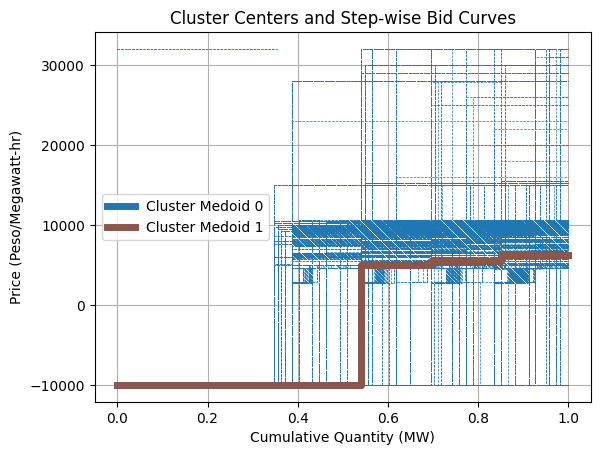

CPU times: total: 13 s
Wall time: 13 s


In [45]:
%%time
# Plotting parameters
thick_line_width = 5
thin_line_width = 0.5

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Get a color map
color_map = plt.get_cmap('tab10')

# Plotting step-wise bid curves from 'df_subset' as thinner lines
for index, row in df_subset.iterrows():
    cluster_no = row['cluster_no']
    cumulative_quantity, price = row[['quantity1', 'price1', 'quantity2', 'price2', 'quantity3', 'price3', 'quantity4', 'price4', 'quantity5', 'price5', 'quantity6', 'price6', 'quantity7', 'price7', 'quantity8', 'price8', 'quantity9', 'price9', 'quantity10', 'price10', 'quantity11', 'price11']].values.reshape(-1, 2).T
    plt.step(cumulative_quantity, price, where='pre', linewidth=thin_line_width, linestyle='--', color=color_map(cluster_no / len(centers_df)))

# Plotting cluster centers from 'centers_df' as thick lines
for index, center_row in centers_df.iterrows():
    cumulative_quantity, price = center_row.values.reshape(-1, 2).T
    plt.step(cumulative_quantity, price, where='pre', linewidth=thick_line_width, label=f'Cluster Medoid {index}', color=color_map(index / len(centers_df)))

# Plotting settings
plt.xlabel('Cumulative Quantity (MW)')
plt.ylabel('Price (Peso/Megawatt-hr)')
plt.title('Cluster Centers and Step-wise Bid Curves')
plt.legend()
plt.grid(True)
plt.show()


# [WIP] K-medoids with both Price-Quantity Scaled

In [ ]:
# Select only the first 100 entries from df_2022
df_subset = df_2022.head(500)

In [ ]:
# Get values from columns
prices = df_subset[['price1', 'price2', 'price3', 'price4', 'price5', 'price6', 'price7', 'price8', 'price9', 'price10', 'price11']].values
quantities = df_subset[['quantity1', 'quantity2', 'quantity3', 'quantity4', 'quantity5', 'quantity6', 'quantity7', 'quantity8', 'quantity9', 'quantity10', 'quantity11']].values

## RobustScaler on Price values

In [ ]:
from sklearn.preprocessing import RobustScaler

# # Assuming prices is a DataFrame with columns price1 to price11
# prices_columns = [f'price{i}' for i in range(1, 12)]
# prices = df_subset[prices_columns]

# Apply Robust scaling to prices
scaler_prices = RobustScaler()
prices_scaled = scaler_prices.fit_transform(prices)
prices_scaled

In [ ]:

# statistics

prices_scaled_stats = {
    'mean': np.mean(prices_scaled, axis=0),
    'std': np.std(prices_scaled, axis=0),
    'min': np.min(prices_scaled, axis=0),
    '25%': np.percentile(prices_scaled, 25, axis=0),
    '50%': np.percentile(prices_scaled, 50, axis=0),
    '75%': np.percentile(prices_scaled, 75, axis=0),
    'max': np.max(prices_scaled, axis=0),
}

# Create a DataFrame for better visualization
prices_scaled_stats_df = pd.DataFrame(prices_scaled_stats, index=[f'Price_{i+1}' for i in range(prices_scaled.shape[1])])

# Display the statistics DataFrame
print(prices_scaled_stats_df)


In [ ]:
# Specify the desired range based on your data
desired_range = (-10, 10)

# Flatten the 2D array into a 1D array
scaled_prices_flat = prices_scaled.flatten()

# Plot histogram with specified range
plt.hist(scaled_prices_flat, bins=20, range=desired_range, color='blue', alpha=0.7)
plt.xlabel('Scaled Prices')
plt.ylabel('Frequency')
plt.title('Distribution of Scaled Prices')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'prices_scaled' is your array
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a box plot to visualize the distribution
sns.boxplot(data=prices_scaled, orient="v", palette="Set2")

plt.title('Box Plot of Scaled Prices')
plt.ylabel('Scaled Prices')
plt.show()


In [ ]:
# Using prices_scaled
def create_stepwise_curves_scaled(prices, quantities):
    step_curves = []
    for i in range(len(prices)):
        step_curves.append(list(zip(quantities[i], prices[i])))
    return step_curves

# Create list of lists containting price,quantity tuples
step_curves = create_stepwise_curves_scaled(prices_scaled, quantities)
step_curves

In [ ]:
num_curves = len(step_curves)
length_of_first_curve = len(step_curves[0]) if num_curves > 0 else 0

print(f"Number of curves: {num_curves}")
print(f"Length of the first curve: {length_of_first_curve}")

In [ ]:
# Test Plot random indices
# Randomly select 10 indices
random_indices = df_subset.sample(n=10).index

# Extract prices and cumulative quantities for the randomly selected indices
selected_prices = df_subset.loc[random_indices, 'price1':'price11'].values
selected_cumulative_quantities = df_subset.loc[random_indices, 'quantity1':'quantity11'].values

# Plotting the selected step-wise bid curves
for i, idx in enumerate(random_indices):
    cumulative_quantity = selected_cumulative_quantities[i]
    price = selected_prices[i]
    plt.step(cumulative_quantity, price, where='pre', label=f'Curve {idx}')

plt.xlabel('Cumulative Quantity (MW)')
plt.ylabel('Price (Peso/Megawatt-hr)')
plt.title('Randomly Selected Step-wise Bid Curves from df_subset')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Display the subset of df_subset for the randomly selected indices
df_subset_random = df_subset.loc[random_indices]
# df_subset_random

In [ ]:
# Change step_curves into 2D numpy array 
step_curves_array = np.array(step_curves).reshape(len(step_curves), -1)
step_curves_array

In [ ]:
print("Shape of step_curves_array:", step_curves_array.shape)

## Run

In [ ]:
from sklearn_extra.cluster import KMedoids
from scipy.stats import wasserstein_distance
from joblib import Parallel, delayed
import numpy as np

# Function to calculate Wasserstein distance
def wasserstein_dist(p1, p2):
    return wasserstein_distance(p1, p2)

# Function to perform K-medoids clustering
def kmedoids_clustering(data, k):
    kmedoids = KMedoids(n_clusters=k, metric=wasserstein_dist, random_state=42)
    kmedoids.fit(data)
    return kmedoids.labels_, kmedoids.cluster_centers_

# Function to calculate Separation Threshold
def calculate_separation_threshold(labels, centers, separation_threshold, p_ref):
    k = len(centers)
    s_ref = wasserstein_dist(centers[0], p_ref)  # Assuming P_ref is the first center
    s_th = separation_threshold * s_ref
    
    for i in range(k):
        distances_within_cluster = [
            wasserstein_dist(step_curves_array[j], centers[i]) 
            for j in range(len(labels)) if labels[j] == i
        ]
        rho_i = sum(1 for dist in distances_within_cluster if dist > s_th) / len(distances_within_cluster)

        if rho_i > tolerance_rate:
            return True

    return False

# Modify process_chunk to return labels along with result
def process_chunk(K, step_curves_array, separation_threshold, tolerance_rate):
    labels, centers = kmedoids_clustering(step_curves_array, K)
    print(f"Processed chunk for K={K}: Labels: {labels}, Centers Shape: {np.shape(centers)}")

    # Check for empty clusters
    empty_clusters = [i for i, cluster_size in enumerate(np.bincount(labels)) if cluster_size == 0]
    if empty_clusters:
        print(f"Warning: Empty clusters found for K={K}, Cluster indices: {empty_clusters}")

    # Print debugging information
    print("Cluster Centers:")
    print(centers)

    result = calculate_separation_threshold(labels, centers, separation_threshold, step_curves_array[0])

    return result, labels, centers


# Function to find optimal number of clusters
def find_optimal_clusters(step_curves_array, K_0, K_max, initial_chunk_size, iterations_within_chunk, separation_threshold, tolerance_rate):
    step_curves_array = step_curves_array.astype(np.float32)
    
    # Initialization
    K = K_0
    P_ref = step_curves_array[0]  # Using the first curve as a reference

    # Initialize the variable to track the optimal number of clusters
    optimal_K = K_0  

    # Store cluster centers and labels here
    centers_list = []  
    labels_list = []

    while K <= K_max:  
        print(f"Processing chunk for K={K}")

        result_found = False  # Flag to track whether a result was found in the inner loop
        # Inside your loop in find_optimal_clusters function
        for _ in range(iterations_within_chunk):
            chunk_size = min(initial_chunk_size, K_max - K)
            chunk_results = list(Parallel(n_jobs=-1)(delayed(process_chunk)(K + i, step_curves_array, separation_threshold, tolerance_rate) for i in range(chunk_size)))

            for result, labels, centers in chunk_results:
                if result:
                    optimal_K = K  # Update the optimal_K variable
                    centers_list.append(centers)
                    labels_list.append(labels)
                    result_found = True
                    break

            if result_found:
                break  # Break out of the inner loop if a result is found
                
        if result_found:
            break  # Break out of the outer loop if a result is found

        # Increment K after the chunk is processed
        K += chunk_size

    # Now optimal_K contains the optimal number of clusters, up to K_max
    print(f"Optimal number of clusters (K): {optimal_K}")
    
    # Return the labels_list
    return labels_list, centers_list

In [ ]:
%%time
# Parameters
K_0 = 2
K_max = 4  # Choose a smaller value for testing
separation_threshold = 0.01  # 1% as separation_threshold_ratio, increase if you think clusters should have larger dissimilarity
tolerance_rate = 0.05  # original was 0.1, increase if you want to be more strict about considering a cluster as separate

# Initial chunk size
initial_chunk_size = 8000
# Number of iterations within each chunk
iterations_within_chunk = 500

# Find optimal clusters
found_labels_list, found_centers_list = find_optimal_clusters(step_curves_array, K_0, K_max, initial_chunk_size, iterations_within_chunk, separation_threshold, tolerance_rate)

In [ ]:
# Assuming 'found_labels_list' is your list of labels after clustering
cluster_labels = found_labels_list[0]

# Add 'cluster_no' column to df_subset using .loc
df_subset.loc[:, 'cluster_no'] = cluster_labels.copy()  # Use .copy() to avoid the warning
df_subset

## Reconstitute centers df

In [ ]:
found_centers_list

In [ ]:
import pandas as pd

# Assuming 'step_curves_array' is your original data for scaling
num_features = len(step_curves[0][0])  # Assuming each step has 'num_features' features
price_indices = range(1, num_features * len(step_curves[0]), num_features)

# Calculate min and max prices
min_prices = step_curves_array[:, price_indices].min(axis=0)
max_prices = step_curves_array[:, price_indices].max(axis=0)
max_prices

In [ ]:
# Function to inverse scale prices
def inverse_scale_prices(scaled_prices, min_prices, max_prices):
    return (scaled_prices * (max_prices - min_prices)) + min_prices

# Create an empty DataFrame for centers_df
centers_df = pd.DataFrame()

# Iterate over the clusters and inverse scale prices
for i, cluster_center in enumerate(found_centers_list):
    # Assuming 'found_centers_list' is a list of numpy arrays for each cluster center
    center_df = pd.DataFrame(cluster_center, columns=[f'quantity{i+1}', f'price{i+1}'])

    # Inverse scale prices for the current cluster
    center_df[f'price{i+1}'] = inverse_scale_prices(center_df[f'price{i+1}'], min_prices, max_prices)

    # Concatenate to the overall centers_df
    centers_df = pd.concat([centers_df, center_df], axis=1)

# Display the final DataFrame
centers_df